#  Preprocessing

In [84]:
import numpy as np
import pandas as pd 
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [85]:
df = pd.read_csv("YesBank_StockPrices.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')
df.index = df["Date"]
df = df.drop(["Date"], axis= 1)

In [86]:
df.tail()

,Open,High,Low,Close
Date,,,,
2020-07-01,25.60,28.30,11.10,11.95
2020-08-01,12.00,17.16,11.85,14.37
2020-09-01,14.30,15.34,12.75,13.15
2020-10-01,13.30,14.01,12.11,12.42
2020-11-01,12.41,14.90,12.21,14.67


In [87]:
df.shape

(185, 4)

In [88]:
df.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [89]:
df.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [90]:
df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

### Plot the Close stock price timeseries

Text(0, 0.5, 'Prices')

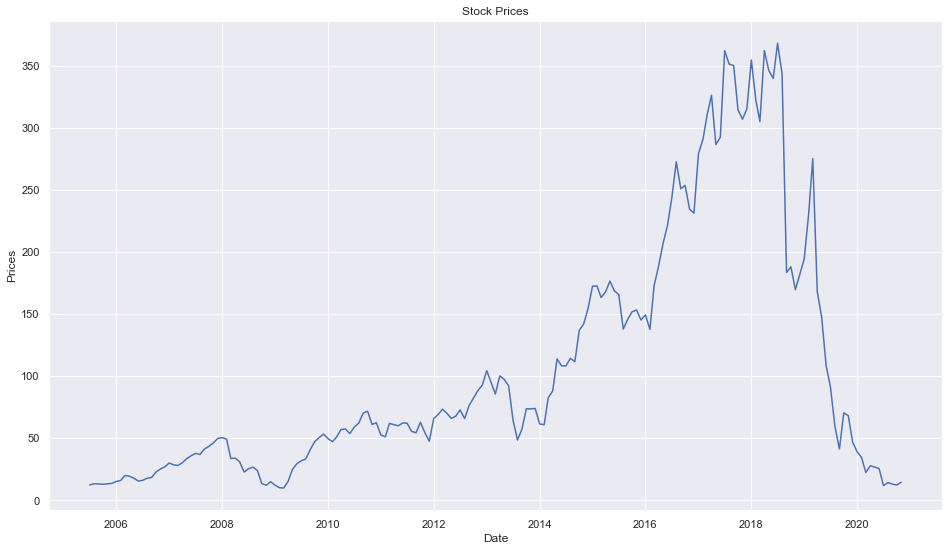

In [91]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=df.index, y="Close", data=df)
plt.title("Stock Prices")
plt.ylabel("Prices")

### Plot all the timeseries to see the trend and seasonality

Text(0, 0.5, 'Prices')

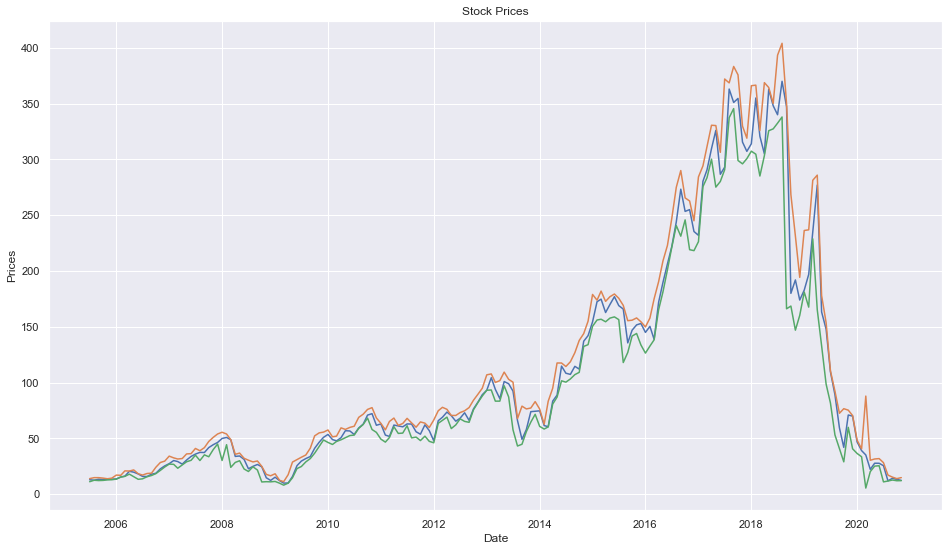

In [92]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=df.index, y="Open", data=df)
sns.lineplot(x=df.index, y="High", data=df)
sns.lineplot(x=df.index, y="Low", data=df)
plt.title("Stock Prices")
plt.ylabel("Prices")

### Augmented Dickey–Fuller test to check if the timeseries is stationary
#### Stationarity exists when we have constant mean and variance

In [93]:
df_test = adfuller(df["Close"], autolag="AIC", regression="ct")

print("1. ADF: ", df_test[0])
print("1. P-value: ", df_test[1])
print("1. Num of Lags: ", df_test[2])
print("1. Num of observations used for ADF Regression and Critical values calculation: ", df_test[3])
print("1. Critical values: ", df_test[0])
for key, val in df_test[4].items():
    print("\t",key,": ",val)

1. ADF:  -1.9185691013655652
1. P-value:  0.6449930413084064
1. Num of Lags:  14
1. Num of observations used for ADF Regression and Critical values calculation:  170
1. Critical values:  -1.9185691013655652
	 1% :  -4.013034503358437
	 5% :  -3.436637782210462
	 10% :  -3.142399780175046


#### The P-value is approximately equal to 0.645 > 0.05. We can't reject the null-hypothesis so the series isn't stationary.

### Decomposing the series of  Close stock prices into "Trend", "Seasonality" and the  "Residuals".

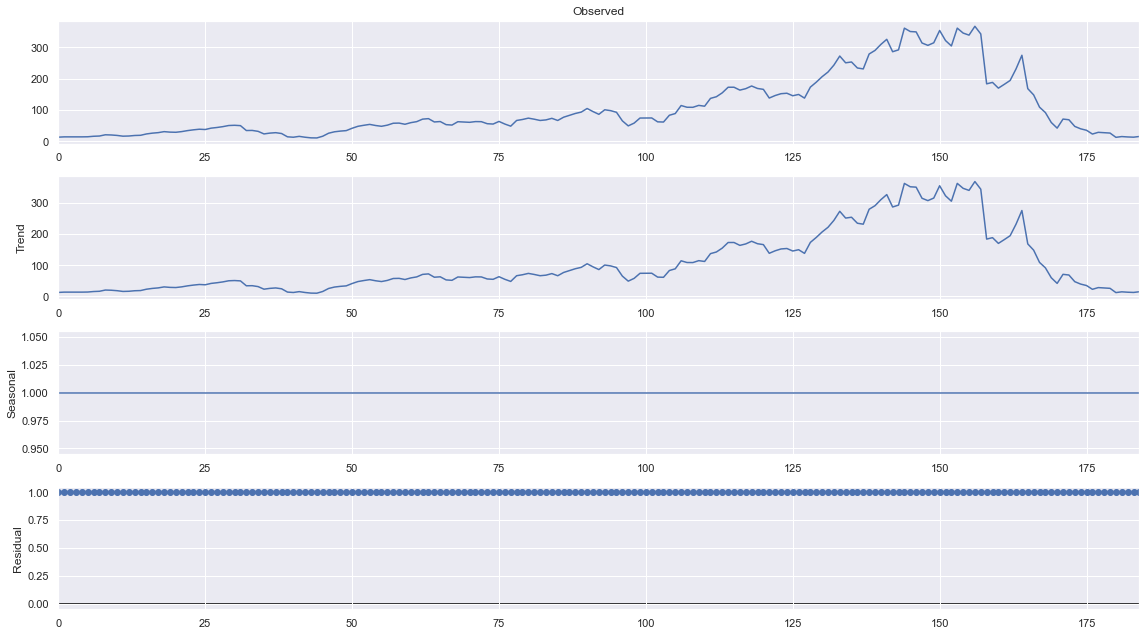

In [95]:
mul_res = sm.tsa.seasonal_decompose(df["Close"].values.ravel(),
                                model="multiplicative",
                               period=1)
mul_fig = mul_res.plot()

#### I used a multiplicative model for decomposing because it is usualy appropriate for economic timeseries. We have a trend but no seasonality 

# Machine learning

### Due to the fact that the Close stock price series has an increasing trend but no seasonality. I will use three models that are suitable for this case(ARIMAX, SARIMAX, HWES)

#### First i will try to make a prediction of the Close stock price using ARIMAX model (X for the exogenous variables that affect the dependent variable).

#### Afterwards i will try to make a prediction using SARIMAX model (Inserting the trend of the series into the model). 

#### Moreover i will try HWES model which does't support exogenous variables to help the forecasting, only trend and/or seasonality.

#### Lastly i wil train my best model in the whole dataset and make predictions of the next twelve months.

In [96]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from sktime.forecasting.all import temporal_train_test_split, plot_series

### ARIMA

In [97]:
y_train, y_test = temporal_train_test_split(df, test_size=12)

y_train.shape, y_test.shape

((173, 4), (12, 4))

In [98]:
wise_fit = auto_arima(y_train["Close"], trace= True, suppress_warnings = True, seasonal=True)
wise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1539.941, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1541.131, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1542.797, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1542.735, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1539.172, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1536.547, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1538.195, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1545.463, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1543.484, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1543.727, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1534.585, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1540.771, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1540.834, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1536.237, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -764.292
Date:                Sun, 28 Mar 2021   AIC                           1534.585
Time:                        15:01:56   BIC                           1544.027
Sample:                             0   HQIC                          1538.416
                                - 173                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8160      0.052    -15.771      0.000      -0.917      -0.715
ma.L1          0.9478      0.027     35.522      0.000       0.896       1.000
sigma2       422.7669     20.126     21.006      0.000     383.320     462.214
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              2672.43
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              77.71   Skew:                            -2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AR-I-MA is a combination of 3 models Auto Regressive(AR), Integrated(I) , Moving Average(MA), with parameters p, d, q. Our best arima model here is ARIMA(1,1,1). 

#### - AR model's parameter(p) is equal to 1. This means that this month's Close stock price can be well explained by last month's price. 

#### - I model's parameter(d) is equal to 1. Here the researcher should know that the model had to go through a diferrencing process in order to make the series stationary. In our case 1 time integration.
#### NOTE: Most economic variables are non-stationary

#### - MA model's parameter(q) is also equal to 1. This means that this month's Close stock price is well explained by the value of the error at this month and the past month's.

#### NOTE 2: The model contains 1 lag each of the dependent variable and the error term

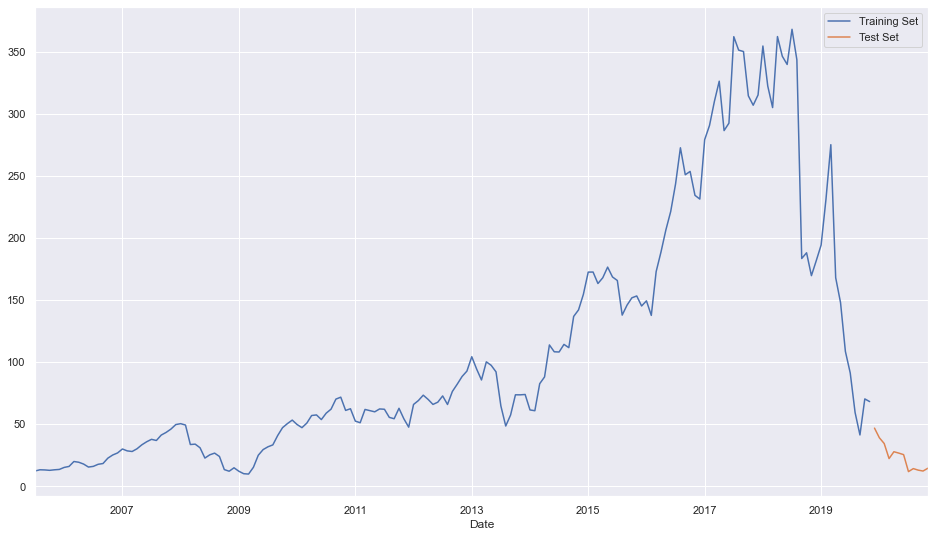

In [99]:
y_train["Close"].plot(label= "Training Set")
y_test["Close"].plot(label= "Test Set")
plt.legend()

In [100]:
model = ARIMA(y_train["Close"], order=(1,1,1), exog= y_train[["Open", "High", "Low"]])
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  172
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -582.666
Method:                       css-mle   S.D. of innovations              7.161
Date:                Sun, 28 Mar 2021   AIC                           1179.331
Time:                        15:02:03   BIC                           1201.364
Sample:                    08-01-2005   HQIC                          1188.270
                         - 11-01-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6319      0.765      2.132      0.033       0.132       3.132
Open             -1.5275      0.053    -28.889      0.000      -1.631      -1.424
High              0.5599      0.047     12.001      0.000       0.468       0.651
Low               0.9981      0.042     23.584      0.000       0.915       1.081
ar.L1.D.Close    -0.1322      0.338     -0.392      0.695      -0.794       0.530
ma.L1.D.Close     0.0364      0.330      0.110      0.912      -0.611       0.684
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.5625           +0.0000j            7.5625            0.5000
MA.1          -27.4373           +0.0000j           27.4373            0.5000
-----------------------------------------------------------------------------
"""

#### Print the predictions of Close stock prices for each month, evaluate the predictions and plot them

In [125]:
start = len(y_train)
end = len(y_train)+ len(y_test)-1
pred = model_fit.predict(start=start, end= end, typ= "levels", exog= y_test[["Open", "High", "Low"]] )
print(pred)

2019-12-01    42.918979
2020-01-01    36.570883
2020-02-01    34.798071
2020-03-01    37.448040
2020-04-01    42.327080
2020-05-01    44.339261
2020-06-01    46.973106
2020-07-01    36.425454
2020-08-01    41.162754
2020-09-01    42.265931
2020-10-01    43.513144
2020-11-01    46.717995
Freq: MS, dtype: float64


In [126]:
rmse = sqrt(mean_squared_error(y_test["Close"], pred))

print("MSE:", mean_squared_error(y_test["Close"], pred))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test["Close"], pred))


MSE: 448.00358002259145
RMSE: 21.166095058432283
MAE: 18.22258115355128


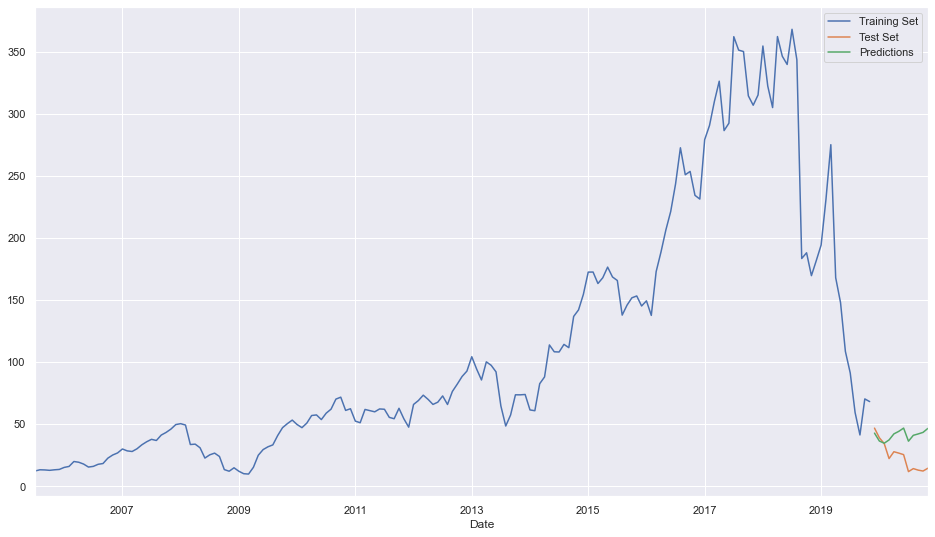

In [127]:
y_train["Close"].plot(label= "Training Set")
y_test["Close"].plot(label= "Test Set")
pred.plot(label= "Predictions")
plt.legend()

## SARIMAX

In [104]:
model2 = SARIMAX(y_train["Close"], order=(1,1,1), exog= y_train[["Open", "High", "Low"]], trend="ct")
model2_fit=model2.fit(disp=False)
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  173
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -581.904
Date:                Sun, 28 Mar 2021   AIC                           1179.809
Time:                        15:02:16   BIC                           1204.989
Sample:                    07-01-2005   HQIC                          1190.025
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0179      0.165      0.109      0.913      -0.305       0.340
drift          0.0001      0.001      0.091      0.928      -0.003       0.003
Open          -0.5391      0.042    -12.776      0.000      -0.622      -0.456
High           0.5368      0.031     17.357      0.000       0.476       0.597
Low            1.0186      0.037     27.806      0.000       0.947       1.090
ar.L1         -0.1164      0.057     -2.049      0.040      -0.228      -0.005
ma.L1         -0.9458      0.036    -26.594      0.000      -1.016      -0.876
sigma2        54.0823      4.016     13.467      0.000      46.211      61.953
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               488.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              15.00   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Print the predictions of Close stock prices for each month, evaluate the predictions and plot them

In [105]:
start = len(y_train)
end = len(y_train)+ len(y_test)-1
pred2 = model2_fit.predict(start=start, end= end, typ= "levels", exog=y_test[["Open", "High", "Low"]] )
print(pred2)

2019-12-01    47.491888
2020-01-01    43.846950
2020-02-01    40.906592
2020-03-01    39.837646
2020-04-01    30.984213
2020-05-01    33.663069
2020-06-01    34.270204
2020-07-01    18.787609
2020-08-01    20.939192
2020-09-01    19.675051
2020-10-01    18.884540
2020-11-01    19.980321
Freq: MS, Name: predicted_mean, dtype: float64


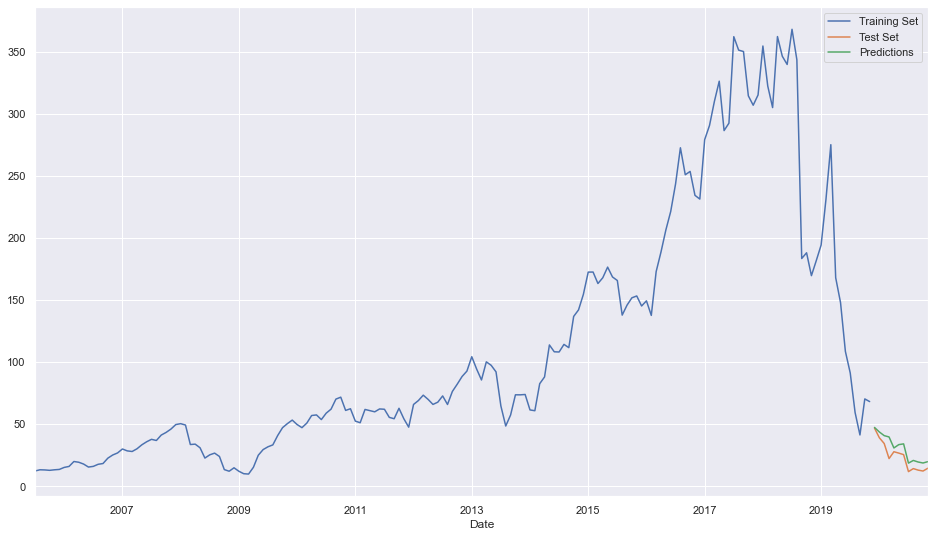

In [106]:
y_train["Close"].plot(label= "Training Set")
y_test["Close"].plot(label= "Test Set")
pred2.plot(label= "Predictions")
plt.legend()

In [107]:
rmse = sqrt(mean_squared_error(y_test["Close"], pred2))

print("MSE:", mean_squared_error(y_test["Close"], pred2))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test["Close"], pred2))

MSE: 58.15786015513452
RMSE: 7.6261300903626426
MAE: 6.596439489893494
MAPE: 659.6439489893494


## Holt Winter’s Exponential Smoothing (HWES)

In [131]:
model3 = ExponentialSmoothing(y_train["Close"],trend="multiplicative", seasonal="multiplicative", damped=False )
model3_fit = model3.fit()
model3_fit.summary()

Dep. Variable:,Close,No. Observations:,173
Model:,ExponentialSmoothing,SSE,62763.623
Optimized:,True,AIC,1051.634
Trend:,Multiplicative,BIC,1102.087
Seasonal:,Multiplicative,AICC,1056.076
Seasonal Periods:,12,Date:,"Sun, 28 Mar 2021"
Box-Cox:,False,Time:,15:28:49
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.1069436,beta,True


#### Print the predictions of Close stock prices for each month, evaluate the predictions and plot them

In [132]:
start = len(y_train)
end = len(y_train)+ len(y_test)-1
pred3 = model3_fit.predict(start=start, end= end)
print(pred3)

2019-12-01    68.580746
2020-01-01    74.982504
2020-02-01    72.835947
2020-03-01    74.952924
2020-04-01    73.784359
2020-05-01    69.618406
2020-06-01    67.592142
2020-07-01    72.730560
2020-08-01    69.086098
2020-09-01    57.723461
2020-10-01    55.600618
2020-11-01    52.615274
Freq: MS, dtype: float64


In [133]:
rmse = sqrt(mean_squared_error(y_test["Close"], pred3))

print("MSE:", mean_squared_error(y_test["Close"], pred3))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test["Close"], pred3))

MSE: 1970.2702841312139
RMSE: 44.387726728581335
MAE: 43.33275325634903


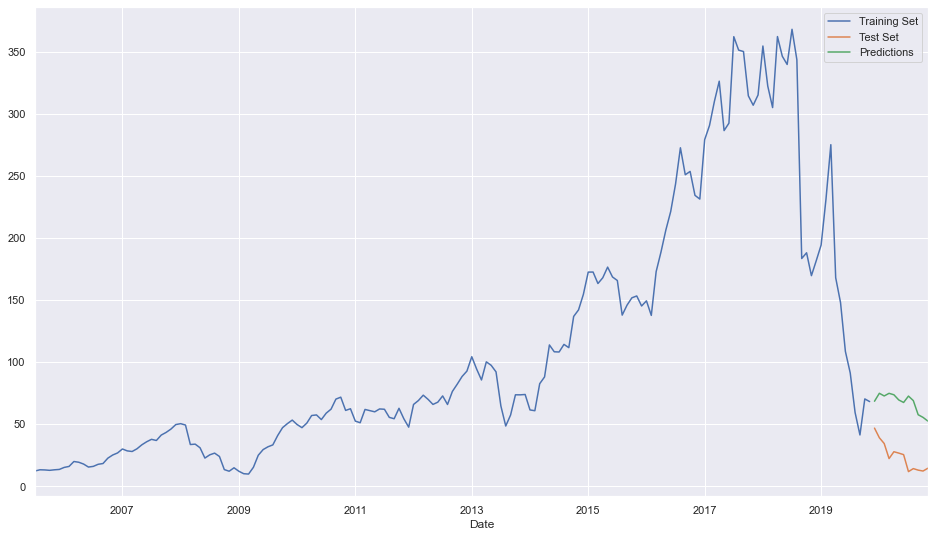

In [134]:
y_train["Close"].plot(label= "Training Set")
y_test["Close"].plot(label= "Test Set")
pred3.plot(label= "Predictions")
plt.legend()

### SARIMAX model catches better the trend of the series and the predictions are better than ARIMA's and HWES's(RMSE: 7.63, MAE: 6.6). Thus i will choose SARIMAX as the final model.

In [108]:
model_final = SARIMAX(df["Close"], order=(1,1,1), exog= df[["Open", "High", "Low"]], trend="ct")
model_final_fit=model_final.fit(disp=False)
model_final_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  185
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -619.524
Date:                Sun, 28 Mar 2021   AIC                           1255.047
Time:                        15:02:30   BIC                           1280.767
Sample:                    07-01-2005   HQIC                          1265.471
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0587      0.148      0.397      0.691      -0.231       0.348
drift         -0.0006      0.001     -0.546      0.585      -0.003       0.002
Open          -0.5199      0.038    -13.795      0.000      -0.594      -0.446
High           0.5393      0.029     18.876      0.000       0.483       0.595
Low            1.0052      0.036     28.073      0.000       0.935       1.075
ar.L1         -0.0811      0.052     -1.552      0.121      -0.184       0.021
ma.L1         -0.9458      0.028    -33.290      0.000      -1.001      -0.890
sigma2        49.6600      3.252     15.273      0.000      43.287      56.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               544.55
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              14.81   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Print and Plot the final predictions

In [120]:
start = len(df)-1
end = len(df)-1 + 12
pred_final = model_final_fit.predict(start=start, end= end, typ= "levels", exog=y_test[["Open", "High", "Low"]] )
print(pred_final)

2020-11-01    14.271418
2020-12-01    42.822685
2021-01-01    38.778013
2021-02-01    35.601518
2021-03-01    34.858185
2021-04-01    25.323675
2021-05-01    27.952515
2021-06-01    28.460657
2021-07-01    13.025058
2021-08-01    14.781416
2021-09-01    13.448694
2021-10-01    12.547097
2021-11-01    13.528886
Freq: MS, Name: predicted_mean, dtype: float64


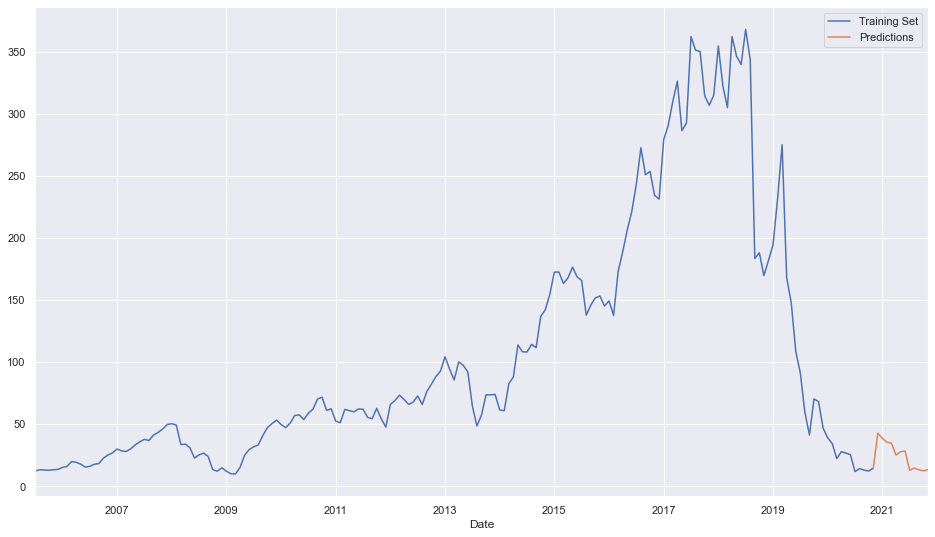

In [121]:
df["Close"].plot(label= "Training Set")
pred_final.plot(label= "Predictions")
plt.legend()